# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
encoder=OneHotEncoder(handle_unknown='ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

#DEBUG = False is not going to run investigating code 
DEBUG = True

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')


# DEBUG = False

In [3]:
#View first couple rows of dataframe
if DEBUG:
    display(azdias.head())
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
    display(azdias.describe().T)
#Comment
    display(azdias.describe())
#View 
    display(feat_info.head())
    display(feat_info.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KONSUMNAEHE,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Reload data
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

#DEBUG = False is not going to run investigating code 
DEBUG = True

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
def convert_to_nan(df, feature_info):
    """FILL OUT
    """
    df = df.copy()
    
    for f in range(len(feature_info)):
        #miss_values is list of data with missing or unknown values to convert to NaN
        miss_values = feature_info.iloc[f]['missing_or_unknown'] 
        miss_values = miss_values.strip(']') 
        miss_values = miss_values.strip('[') 
        miss_values = miss_values.split(sep=',') 
        miss_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in miss_values] 
        if miss_values != ['']: 
            df = df.replace({feature_info.iloc[f]['attribute']: miss_values}, np.nan)
    return df



In [6]:
#Make sure Nans have been added in pace of missing values
if DEBUG:
    display(convert_to_nan(azdias, feat_info).head())





,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias = convert_to_nan(azdias, feat_info)


if DEBUG:
    summary = azdias.isna().sum()
    print(summary)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

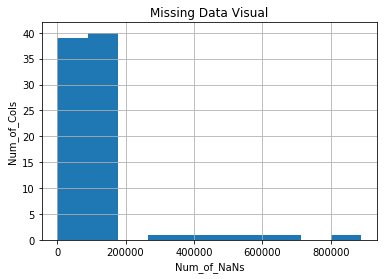

In [8]:
# Investigate patterns in the amount of missing data in each column.

if DEBUG:
    n, bins, patches = plt.hist(summary, 10)


    plt.xlabel('Num_of_NaNs')
    plt.ylabel('Num_of_Cols')
    plt.title('Missing Data Visual')

    plt.grid(True)
    plt.show()



In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def filter_col_nan(df, max_col_nan_filter):
    """Find and remove cols w/ excess NaNs
    
    """
    df = df.copy()
    #filter column nan amount
    total_cols = len(df.columns)
    keep_cols = []
    remove_cols = []
    for (index, colname) in enumerate(df):
        nan_count = df[colname].isna().sum()
        if nan_count < max_col_nan_filter:
            keep_cols.append(colname)
        else:
            remove_cols.append(colname)

       #Drop excess NaN cols
    df_keep_cols = df.loc[:,keep_cols]
    df_remove_cols = df.loc[:,remove_cols]
    
    print(f'Removed {total_cols - len(df_keep_cols.columns):,} columns with rows {max_col_nan_filter:,} or greater than NaN values')   
    print(f'The columns that were removed are:{remove_cols}')
    

    return df_keep_cols, df_remove_cols

In [10]:
azdias_keep_cols, azdias_remove_cols = filter_col_nan(azdias, 300000)


print(azdias.shape, azdias_keep_cols.shape, azdias_remove_cols.shape)

Removed 6 columns with rows 300,000 or greater than NaN values
The columns that were removed are:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
(891221, 85) (891221, 79) (891221, 6)


#### Discussion 1.1.2: Assess Missing Data in Each Column
Are there any patterns in missing values?
A few columns have an excess of missing data.


Which columns were removed from the dataset?
The columns with over 300k NaN values have been removed from the dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?
if DEBUG:
    summary = azdias.isna().sum(axis=1)
    print(summary)



0         49
1          4
2          4
3          9
4          3
5          2
6          5
7          4
8          4
9          3
10         3
11        53
12        10
13        11
14        53
15        11
16         9
17        53
18         9
19         5
20        16
21         6
22         6
23        11
24        53
25         9
26        24
27         5
28         4
29         4
          ..
891191     1
891192     4
891193     2
891194     2
891195     2
891196     2
891197     2
891198     4
891199     5
891200     5
891201     3
891202     5
891203    20
891204     2
891205     3
891206     3
891207     2
891208     6
891209     5
891210     4
891211     4
891212     4
891213     3
891214     4
891215     5
891216     6
891217     7
891218     9
891219     5
891220     6
Length: 891221, dtype: int64


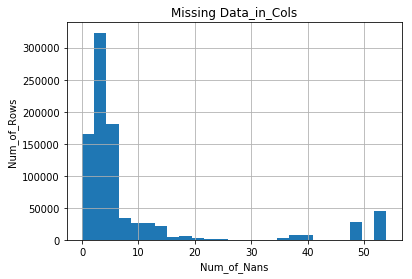

In [12]:
# Investigate patterns in the amount of missing data in each column.
if DEBUG:
    n, bins, patches = plt.hist(summary, 25)


    plt.xlabel('Num_of_Nans')
    plt.ylabel('Num_of_Rows')
    plt.title('Missing Data_in_Cols')

    plt.grid(True)
    plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


def filter_row_nan(df, max_row_nan_filter):
    """Find and remove rows w/ excess NaNs
    
    """
    df = df.copy()

    total_rows = len(df)
    #Filter row nan amount
    df['num_null'] = df.isnull().sum(axis=1)
    
    df_less = df[df['num_null'] <= max_row_nan_filter]
    df_more = df[df['num_null'] > max_row_nan_filter]
    

    
    print(f'Removed {total_rows - len(df_less):,} rows with columns {max_row_nan_filter:,} or greater than NaN values')   

    
    return df_less.drop(columns=['num_null']), df_more.drop(columns=['num_null'])

    
    
    
    
# azdias_rc, azdias__c = filter_row_nan(azdias_keep_cols, 25)
# azdias_r_, azdias___ = filter_row_nan(azdias_remove_cols, 25)

azdias_keep_rows, azdias_remove_rows = filter_row_nan(azdias, 25)





Removed 93,837 rows with columns 25 or greater than NaN values


In [14]:
# #Create list of columns that appear in both dfs
# combined_cols = list(less_nan_rows['name']) + list(more_nan_rows['name'])
# combined_cols = set(combined_cols)
# # combined_cols = less_nan_rows.merge(more_nan_rows, how='inner', on='name')
# # print(combined_cols)

# less_cols = list(less_nan_rows['name'])
# more_cols = list(more_nan_rows['name'])
# combined_list = []
# for name in combined_cols:
#     if name in less_cols and name in more_cols:
#         combined_list.append(name)
# print(combined_list)

# five_col_list = combined_list[:5]
# print(five_col_list)

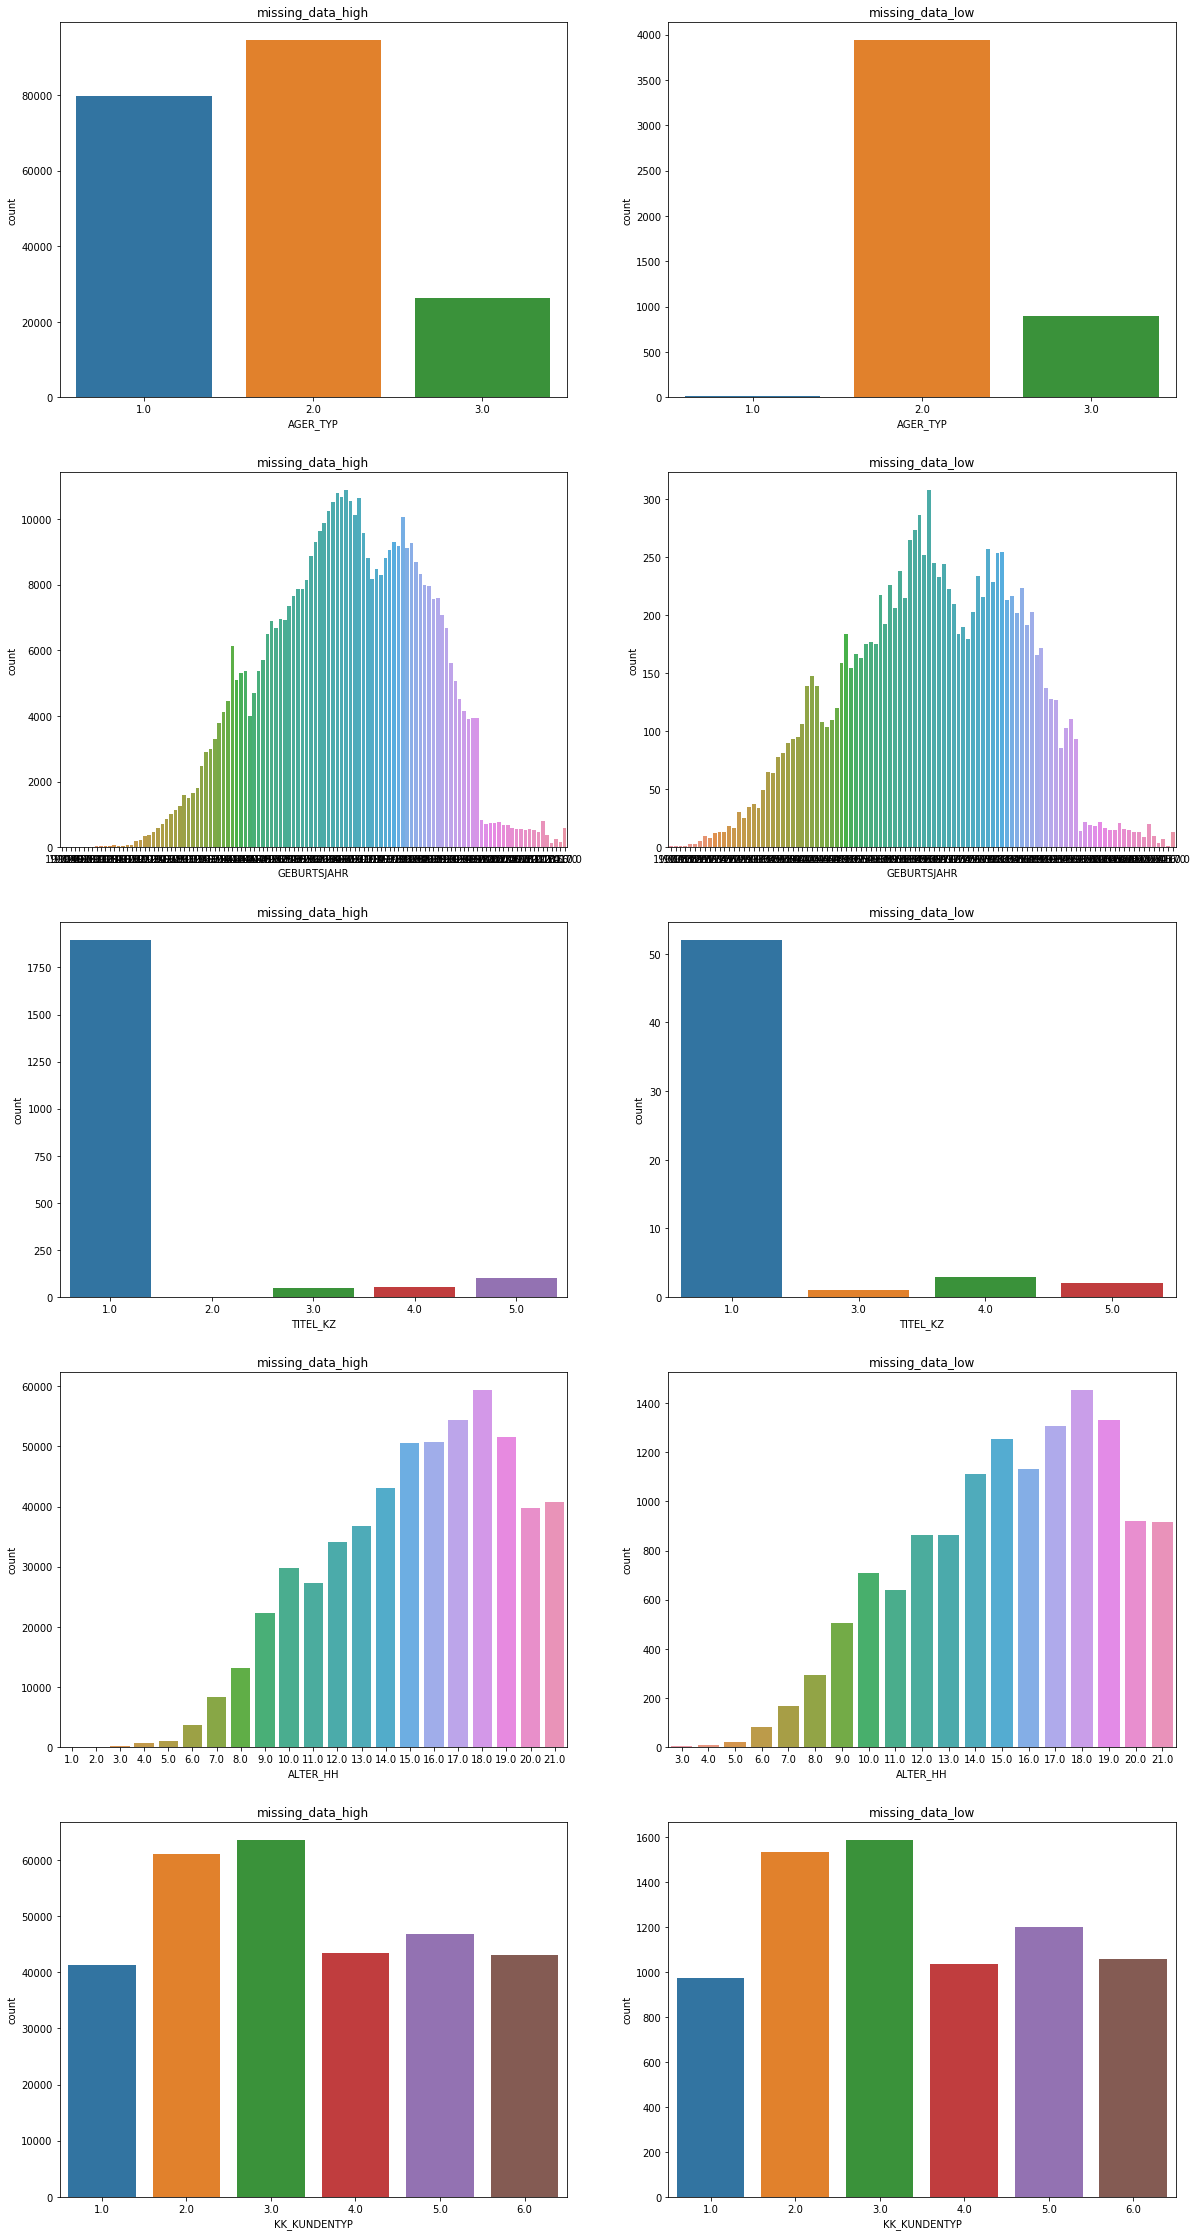

In [15]:
#Function to apply seaborn countplot to each column
#Use seaborn .countplot() to view NaN frequencies
import seaborn as sns


#######create matplotlib subplot with countplot as arg
cols = azdias_remove_cols.columns[:5]

n = 0
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 40))
for col in cols:
    sns.countplot(azdias_keep_rows.loc[:, col], ax=axs[n,0])
    axs[n,0].set_title('missing_data_high')
    sns.countplot(azdias_remove_rows.loc[:, col], ax=axs[n,1])
    axs[n,1].set_title('missing_data_low')
    n+=1

  

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

It seems as though the data with high missing values gives us a lot less data than the data with few missing values. The data with high missing values each seem to have a certain area in which there is more response. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
pd.set_option('display.max_rows', 500)

In [17]:
# How many features are there of each data type?
feat_info.head()
pd.get_dummies(feat_info['type']).sum()


categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
azdias_keep_rows.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [19]:
def encode_column(df, x, encoder):
    """Encode multiple columns in DataFrame
    """
    df = df.copy()
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    values = encoder.fit_transform(df[[x]]).toarray()
    columns = [f'{x}_{col}' for col in range(values.shape[1])]
#     print(len(columns))
    enc_df = pd.DataFrame(values, columns=columns)
    df = df.join(enc_df)
    df = df.drop(x, axis=1)
    return df

In [20]:
def categorical_columns(df, feat):
    
    att_list = df.columns
    cond_1 = feat['attribute'].isin(att_list)
    cond_2 = feat['type'] == 'categorical'
    categorical_cols = feat[cond_1 & cond_2]
    column_attribute = categorical_cols['attribute']

    print(f"Columns {list(column_attribute)} are of `categorical` type.")
    # Turn column names with categorical type to a list
    list_cols_cat = column_attribute.values.tolist()
#     print(f'listcolscat:{list_cols_cat}')
    #Gather list information from cleaned azdias data
    df_cat_cols = df[list_cols_cat]
#     print(f'df cat cols:{df_cat_cols}')
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    binary_feature = []
    multi_level_feature = []
    for feature in list_cols_cat:
        if (len(df[feature].unique())==2):
            binary_feature.append(feature)
        elif (len(df[feature].unique())>2):
            multi_level_feature.append(feature)
    print(f'Multi level feature columns:{multi_level_feature}')
    print(f'Binary feature columns:{binary_feature}')
    
    for x in multi_level_feature:
        if x == np.nan:
            df = encode_column(df, x, enc)
    
    
    return df


In [21]:
azdias_encoded = categorical_columns(azdias_keep_rows, feat_info)

Columns ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [22]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')


def encode_column(df, x, encoder):
    """Encode multiple columns in DataFrame
    """
    df = df.copy()
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    values = encoder.fit_transform(df[[x]]).toarray()
    columns = [f'{x}_{col}' for col in range(values.shape[1])]
#     print(len(columns))
    enc_df = pd.DataFrame(values, columns=columns)
    df = df.join(enc_df)
    df = df.drop(x, axis=1)
    # Encode multi level feature columns
    for x in multi_level_feature:
        if x == np.nan:
            df = encode_column(df, x, enc)
    # Re-encode categorical variable(s) to be kept in the analysis.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['W','O'],['0', '1'])
    return df





#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I found that a lot of the columns had close to , or 0 Nans. I kept all of the columns as is with the exception of 'OST_WEST_KZ'.
I replaced the W (for west) with 0 and O (for east) with 1. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_encoded.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [24]:
def fast_apply(df, func, columns):
    rows = [
        row + func(row)
        for row in df.itertuples()
    ]
    columns = ['old_index'] + list(df.columns) + columns
    df = pd.DataFrame(rows, columns=columns)
    df = df.drop(columns='old_index')
    return df

In [25]:
MOVEMENT_MAINSTREAM = [1, 3, 5, 8, 10, 12, 14]


def pj_map(key):
    """ Maps key to decade and movement
    
    
    
    """
    movement = 0 if key in MOVEMENT_MAINSTREAM else 1
    if key in [1, 2]:
        return 40, movement
    if key in [3, 4]:
        return 50, movement
    if key in [5, 6, 7]:
        return 60, movement
    if key in [8, 9]:
        return 70, movement
    if key in [10, 11, 12, 13]:
        return 80, movement
    if key in [14, 15]:
        return 90, movement
    
    return (np.nan, np.nan)
    
assert pj_map(4) == (50, 1)  

assert isinstance (pj_map(4), tuple)
assert isinstance (pj_map(0), tuple)
assert isinstance (pj_map(np.nan), tuple)

In [26]:

def pj_row(row):
    """Row is a named tuple with they key of named tuple being column name
       
    Returns tuple
    
    """
    
    key = row.PRAEGENDE_JUGENDJAHRE
    return pj_map(key)



df_mixed = azdias_encoded.pipe(fast_apply, pj_row, ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'])

df_mixed[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
0,14.0,90.0,0.0
1,15.0,90.0,1.0
2,8.0,70.0,0.0
3,8.0,70.0,0.0
4,3.0,50.0,0.0


In [27]:
extracted_col = df_mixed[['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']]
print(extracted_col)

azdias_encoded = azdias_encoded.join(extracted_col)


        PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOVEMENT
0                               90.0                             0.0
1                               90.0                             1.0
2                               70.0                             0.0
3                               70.0                             0.0
4                               50.0                             0.0
5                               80.0                             0.0
6                               70.0                             0.0
7                               80.0                             1.0
8                               90.0                             1.0
9                               50.0                             0.0
10                              70.0                             0.0
11                              90.0                             1.0
12                              60.0                             0.0
13                              90

In [28]:
azdias_encoded = azdias_encoded.drop(azdias_encoded[['PRAEGENDE_JUGENDJAHRE']], axis='columns')

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_encoded['CAMEO_INTL_2015'].head()


1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [30]:
azdias_encoded['CAMEO_INTL_2015'] = azdias_encoded['CAMEO_INTL_2015'].fillna(0)
    
azdias_encoded['CAMEO_INTL_2015'] = azdias_encoded['CAMEO_INTL_2015'].astype('int32')
        
        
        
        
        
        
        

In [31]:
azdias_encoded['CAMEO_INTL_2015'].dtypes


dtype('int32')

In [32]:
                 
azdias_encoded['tens'] = azdias_encoded['CAMEO_INTL_2015']//10
azdias_encoded['ones'] = azdias_encoded['CAMEO_INTL_2015']%10 
tens_map = {1:'Wealthy Households',2:'Prosperous households',
    3:'Comfortable Households',4:'Less Affluent households' ,5:'Poorer households',
    -1:'unknown'}
ones_map = {1:'Pre-Family Couples & Singles',2:'Young Couples With Children',
    3:'Families With School Age Children',4:'Older Families &  Mature Couples' ,5:'Elders In Retirement',
    -1:'unknown'}
azdias_encoded['WEALTH_STATUS_CAMEO_INTL_2015'] = azdias_encoded['tens'].map(tens_map)
azdias_encoded['LIFESTAGE_CAMEO_INTL_2015'] = azdias_encoded['ones'].map(ones_map)


In [33]:
one_hot_encoded_data = pd.get_dummies(azdias_encoded, columns = ['WEALTH_STATUS_CAMEO_INTL_2015', 'LIFESTAGE_CAMEO_INTL_2015'])

In [34]:
azdias_encoded = one_hot_encoded_data

In [35]:

azdias_encoded = azdias_encoded.drop(azdias_encoded[['tens', 'ones']], axis='columns')
azdias_encoded = azdias_encoded.drop(azdias_encoded[['CAMEO_DEU_2015']], axis='columns')


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
For 'PRAEGENDE_JUGENDJAHRE' I re-encoded each row based on the conditions in the function pj_map(). I separated 'CAMEO_INTL_2015' by their tens and ones places as instructed and set each in a new column. For both Columns I deleted the old columns before they were separated to get rid of irrelevant information. I dropped 'CAMEO_DEU_2015'.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [37]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
from sklearn.preprocessing import OneHotEncoder

In [39]:
def convert_to_nan(df, feature_info):
    """Convert missing value codes into NaNs
    """
    df = df.copy()
    
    for f in range(len(feature_info)):
        #miss_values is list of data with missing or unknown values to convert to NaN
        miss_values = feature_info.iloc[f]['missing_or_unknown'] 
        miss_values = miss_values.strip(']') 
        miss_values = miss_values.strip('[') 
        miss_values = miss_values.split(sep=',') 
        miss_values = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in miss_values] 
        if miss_values != ['']: 
            df = df.replace({feature_info.iloc[f]['attribute']: miss_values}, np.nan)
    # sum of NaNs
    
    summary = df.isna().sum().sum()
    print(f'Converted {summary:,} values to NaNs')
    return df


In [40]:
def filter_col_nan(df, max_col_nan_filter):
    """Find and remove cols w/ excess NaNs
    
    """
    df = df.copy()
    #filter column nan amount
    total_cols = len(df.columns)
    keep_cols = []
    remove_cols = []
    for (index, colname) in enumerate(df):
        nan_count = df[colname].isna().sum()
        if nan_count < max_col_nan_filter:
            keep_cols.append(colname)
        else:
            remove_cols.append(colname)

       #Drop excess NaN cols
    df_keep_cols = df.loc[:,keep_cols]
    df_remove_cols = df.loc[:,remove_cols]
    
    print(f'Removed {total_cols - len(df_keep_cols.columns):,} columns with rows {max_col_nan_filter:,} or greater than NaN values')   
    print(f'The columns that were removed are:{remove_cols}')
    

    return df_keep_cols, df_remove_cols

In [41]:
def filter_row_nan(df, max_row_nan_filter):
    """Find and remove rows w/ excess NaNs
    
    """
    df = df.copy()

    total_rows = len(df)
    #Filter row nan amount
    df['num_null'] = df.isnull().sum(axis=1)
    
    df_less = df[df['num_null'] <= max_row_nan_filter]
    df_more = df[df['num_null'] > max_row_nan_filter]
    

    
    print(f'Removed {total_rows - len(df_less):,} rows with columns {max_row_nan_filter:,} or greater than NaN values')   

    
    return df_less.drop(columns=['num_null']), df_more.drop(columns=['num_null'])





In [42]:
def filter_out_nan(df, max_col_nan_filter, max_row_nan_filter):
    """Find and remove rows w/ excess NaNs
    
    """
    df = df.copy()
    #filter column nan amount
    total_cols = len(df.columns)
    total_rows = len(df)
    keep_cols = []
    for (index, colname) in enumerate(df):
        nan_count = df[colname].isna().sum()
        if nan_count < max_col_nan_filter:
            keep_cols.append(colname)
    
    #Drop excess NaN cols
    df = df.loc[:,keep_cols]
    #Filter row nan amount
    df['num_null'] = df.isnull().sum(axis=1)
    df = df[df['num_null'] <= max_row_nan_filter].loc[:,keep_cols]
    
    print(f'Removed {total_cols - len(df.columns):,} columns with rows {max_col_nan_filter:,} or greater than NaN values')   
    print(f'Removed {total_rows - len(df):,} rows with columns {max_row_nan_filter:,} or greater than NaN values')   

    return df


In [43]:
# from sklearn.preprocessing import OneHotEncoder
# encoder=OneHotEncoder(handle_unknown='ignore')
# def encode_column(df, encoder):
#     """Encode multiple columns in DataFrame
#     """
    
#     df = df.copy()
#     values = encoder.fit_transform(df[[x]]).toarray()
#     columns = [f'{x}_{col}' for col in range(values.shape[1])]
# #     print(len(columns))
#     enc_df = pd.DataFrame(values, columns=columns)
#     df = df.join(enc_df)
#     df.drop(x, inplace=True, axis=1)
    
#     return df, x

In [44]:
def categorical_columns(df, feat):
    
    att_list = df.columns
    cond_1 = feat['attribute'].isin(att_list)
    cond_2 = feat['type'] == 'categorical'
    categorical_cols = feat[cond_1 & cond_2]
    column_attribute = categorical_cols['attribute']

    print(f"Columns {list(column_attribute)} are of `categorical` type.")
    # Turn column names with categorical type to a list
    list_cols_cat = column_attribute.values.tolist()
#     print(f'listcolscat:{list_cols_cat}')
    #Gather list information from cleaned azdias data
    df_cat_cols = df[list_cols_cat]
#     print(f'df cat cols:{df_cat_cols}')
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    binary_feature = []
    multi_level_feature = []
    for feature in list_cols_cat:
        if (len(df[feature].unique())==2):
            binary_feature.append(feature)
        elif (len(df[feature].unique())>2):
            multi_level_feature.append(feature)
    print(f'Multi level feature columns:{multi_level_feature}')
    print(f'Binary feature columns:{binary_feature}')
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['W','O'],['0', '1'])
    
    # One hot encode multi level features
    for x in multi_level_feature:
        if x == np.nan:
#             df = encode_column(df, x, enc)
            encoder=OneHotEncoder(handle_unknown='ignore')
            values = encoder.fit_transform(df[[x]]).toarray()
            columns = [f'{x}_{col}' for col in range(values.shape[1])]
            enc_df = pd.DataFrame(values, columns=columns)
            df = df.join(enc_df)
            df = df.drop(x, axis=1)
    
    
    return df

In [45]:
def fast_apply(df, func, columns):
    rows = [
        row + func(row)
        for row in df.itertuples()
    ]
    columns = ['old_index'] + list(df.columns) + columns
    df = pd.DataFrame(rows, columns=columns)
    df = df.drop(columns='old_index')
    return df

In [46]:
MOVEMENT_MAINSTREAM = [1, 3, 5, 8, 10, 12, 14]


def pj_map(key):
    """ Maps key to decade and movement
    
    
    
    """
    movement = 0 if key in MOVEMENT_MAINSTREAM else 1
    if key in [1, 2]:
        return 40, movement
    if key in [3, 4]:
        return 50, movement
    if key in [5, 6, 7]:
        return 60, movement
    if key in [8, 9]:
        return 70, movement
    if key in [10, 11, 12, 13]:
        return 80, movement
    if key in [14, 15]:
        return 90, movement
    
    return (np.nan, np.nan)
    
assert pj_map(4) == (50, 1)  

assert isinstance (pj_map(4), tuple)
assert isinstance (pj_map(0), tuple)
assert isinstance (pj_map(np.nan), tuple)

In [47]:
def pj_row(row):
    """Row is a named tuple with they key of named tuple being column name
       
    Returns tuple
    
    """
    
    key = row.PRAEGENDE_JUGENDJAHRE
    return pj_map(key)



In [48]:
def split_decade_movement(df):
    """Split PRAEGENDE_JUGENDJAHRE into two new columns. 
    
    PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT
    
    Drop PRAEGENDE_JUGENDJAHRE column.
    
    """
    df = df.copy()
    
    df_mixed = df.pipe(fast_apply, pj_row, ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'])
    extracted_col = df_mixed[['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']]

    df = df.join(extracted_col)
    df.copy()
    df.drop(df[['PRAEGENDE_JUGENDJAHRE']], inplace=True, axis='columns')

    return df


In [49]:
def fix_cameo(df):
    """Remove NaNs from ['CAMEO_INTL_2015'] and convert to 'int32'.
    
    Divides ['CAMEO_INTL_2015'] into two new cols: ['CAMEO_INTL_2015_WEALTH_STATUS'] and ['CAMEO_INTL_2015_LIFESTAGE']
    
    Based on tens and one places. 
    
    """
    #CAMEO 2015
    df = df.copy()
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna(0)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int32')
    
    df['tens'] = df['CAMEO_INTL_2015']//10
    df['ones'] = df['CAMEO_INTL_2015']%10 
    tens_map = {1:'Wealthy Households',2:'Prosperous households',
    3:'Comfortable Households',4:'Less Affluent households' ,5:'Poorer households',
    -1:'unknown'}
    ones_map = {1:'Pre-Family Couples & Singles',2:'Young Couples With Children',
    3:'Families With School Age Children',4:'Older Families &  Mature Couples' ,5:'Elders In Retirement',
    -1:'unknown'}
    df['WEALTH_STATUS_CAMEO_INTL_2015'] = df['tens'].map(tens_map)
    df['LIFESTAGE_CAMEO_INTL_2015'] = df['ones'].map(ones_map)
    
    df = pd.get_dummies(df, columns = ['WEALTH_STATUS_CAMEO_INTL_2015', 'LIFESTAGE_CAMEO_INTL_2015'])
    drop_columns = ['tens', 'ones', 'CAMEO_DEU_2015']
    df = df.drop(columns=drop_columns)

    return df

In [50]:
def clean_data(df, feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = df.copy()
    # Put in code here to execute all main cleaning steps:
    df = convert_to_nan(df, feat)
    
    # remove selected columns and rows, ...
    #Find and remove rows w/ excess NaNs
    df_keep_c, df_remove_c = filter_col_nan(df, max_col_nan_filter=300000)
    
    df_keep_r, df_remove_r = filter_row_nan(df_keep_c, max_row_nan_filter=25)
    
    df = df_keep_r
    
#     df = filter_out_nan(df, max_col_nan_filter=300000, max_row_nan_filter=25)
    
    df = categorical_columns(df, feat_info)
    
    df = split_decade_movement(df)
    
    df = fix_cameo(df)
    
    
    # Return the cleaned dataframe.
    return df

In [51]:
azdias =  clean_data(azdias, feat_info)

Converted 8,373,929 values to NaNs
Removed 6 columns with rows 300,000 or greater than NaN values
The columns that were removed are:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Removed 93,260 rows with columns 25 or greater than NaN values
Columns ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [52]:
azdias['OST_WEST_KZ'].head()

1    0
2    0
3    0
4    0
5    0
Name: OST_WEST_KZ, dtype: object

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [53]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
from sklearn.preprocessing import OneHotEncoder
azdias =  clean_data(azdias, feat_info)

Converted 8,373,929 values to NaNs
Removed 6 columns with rows 300,000 or greater than NaN values
The columns that were removed are:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Removed 93,260 rows with columns 25 or greater than NaN values
Columns ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [54]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
def get_imputer(df):
    df = df.copy()
    imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
    df = imp.fit(df)
    return df
    
def nan_imputer(df):
    """Apply Imputer to DataFrame to convert all NaN objects to the median num in each col
    
    """
    df = df.copy()
    imp = get_imputer(df)
    data = imp.transform(df)
#     assert isinstance(df, pd.DataFrame)
    print(data.shape)
    columns = df.columns.values.tolist()
    df_imputed = pd.DataFrame(data,columns=columns)
    return df_imputed




In [55]:
azdias_imputed = nan_imputer(azdias)

(797961, 89)


In [56]:
columns = azdias.columns.values.tolist()
df_azdias = pd.DataFrame(azdias_imputed,columns=columns)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided to use scikit learn imputer to impute all 'NaNs' to the median number in each column. Median seemed to be the best option as most-frequent could skew data more towards the most-frequented value in each row depending on how many 'NaNs' were in each column. I felt that median would more-so fairly disperse the replaced 'NaN' value rather than mean due to the mean value keeping data too central.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def get_scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    return scaler

def get_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)
    return pca
    
    
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    data=data.copy()
    scaler = get_scaler(df=data)
    data = scaler.transform(data)
    pca = get_pca(data, n_components)
    X_pca = pca.transform(data)
    
    
    
#     X = StandardScaler().fit_transform(data)
#     pca = PCA(n_components)
#     X_pca = pca.fit_transform(X)
    
    return pca, X_pca





In [58]:
pca, X_pca = do_pca(n_components=None, data=df_azdias)

n_samples = X_pca.shape[0]
n_features = X_pca.shape[1]
print(n_samples, n_features)


797961 89


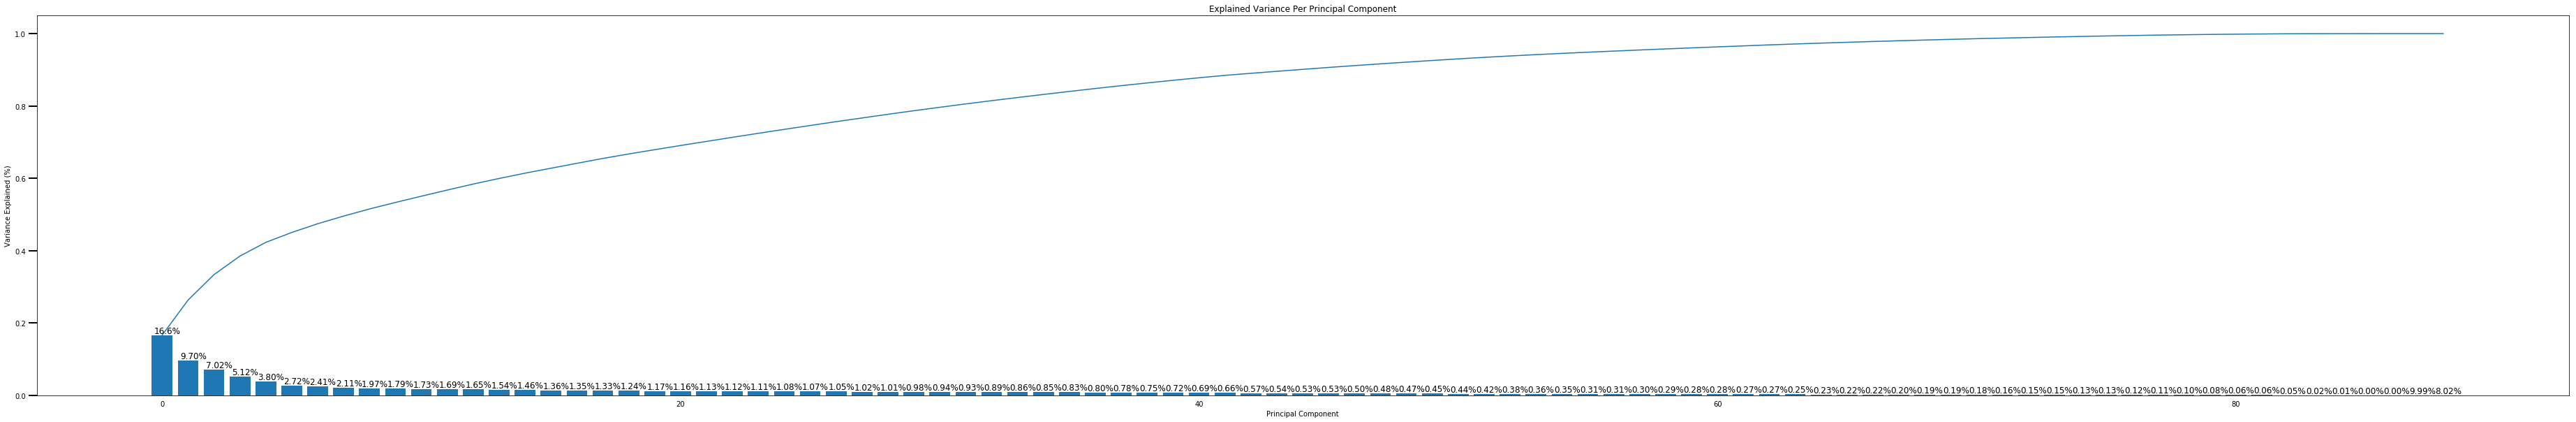

In [59]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(65, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(n_components=20, data=df_azdias)


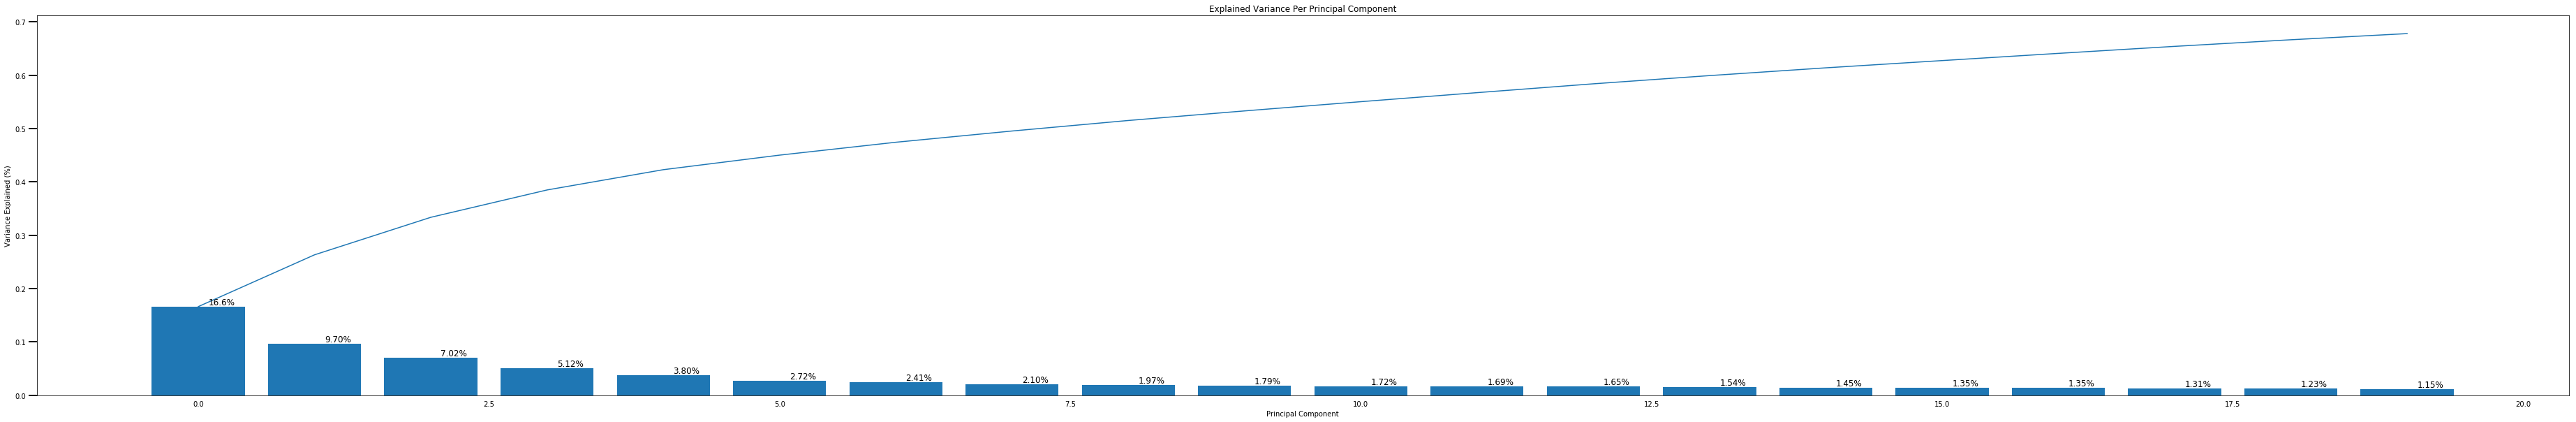

In [61]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
I have decided to retain 20 principal components for the enxt step of analysis. The number of compenents accounted for 60% of the data and went down to a variance of 1.14%


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:

pcnames = [f'PC{i+1}' for i in range(pca.n_components_)]

df_pca_loadings = pd.DataFrame(pca.components_, columns=list(df_azdias.columns), index=pcnames)






In [63]:
def print_component(pca, comp):
    if comp <= len(pca.components_):
        weight_df = pd.DataFrame({'weight': pca.components_[comp]}, index=df_pca_loadings.columns)
        print("Most weighted features for the component: ", comp)
        print(weight_df.sort_values(by=['weight']).head(5))
        print(weight_df.sort_values(by=['weight']).tail(5))
    else:
        print('That is not the right input, please read the docstring before continuing.')
        


In [64]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component(pca, 1)

#most: religion, money saver, dutiful, cultural minded, tradition minded
#least: return type, sensual minded, prepared, event-oriented, estimated age

Most weighted features for the component:  1
                         weight
SEMIO_REL             -0.275848
FINANZ_SPARER         -0.256232
SEMIO_PFLICHT         -0.246985
SEMIO_TRADV           -0.244111
FINANZ_UNAUFFAELLIGER -0.234274
                        weight
RETOURTYP_BK_S        0.160424
SEMIO_LUST            0.192597
FINANZ_VORSORGER      0.242538
SEMIO_ERL             0.244617
ALTERSKATEGORIE_GROB  0.278147


In [65]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component(pca, 2)
#most: gender, combative attitude, dominant-minded, critical-minded, rational
#least: low financial interest, cultural-minded, family-minded, socially-minded, dreamful

Most weighted features for the component:  2
              weight
ANREDE_KZ  -0.360820
SEMIO_KAEM -0.330360
SEMIO_DOM  -0.307099
SEMIO_KRIT -0.267211
SEMIO_RAT  -0.218948
                     weight
FINANZ_MINIMALIST  0.166283
SEMIO_KULT         0.225582
SEMIO_FAM          0.239190
SEMIO_SOZ          0.252620
SEMIO_VERT         0.337102


In [66]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component(pca, 3)

#most: Likelihood of children in household, Distance to city center, Distance to nearest urban center, Number of 1-2 family houses in the PLZ8 region
#least:Number of adults in household, Family type, Lifestage

Most weighted features for the component:  3
                  weight
W_KEIT_KIND_HH -0.222467
INNENSTADT     -0.144869
BALLRAUM       -0.133461
WOHNLAGE       -0.127981
PLZ8_ANTG1     -0.106467
                       weight
ANZ_PERSONEN         0.315654
LP_LEBENSPHASE_FEIN  0.348465
LP_LEBENSPHASE_GROB  0.358899
LP_FAMILIE_FEIN      0.368194
LP_FAMILIE_GROB      0.370786


### Discussion 2.3: Interpret Principal Components


It seems as though the data that holds the most weight relates to household, family, mentality, values, and location.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
df_pca_loadings.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,WEALTH_STATUS_CAMEO_INTL_2015_Comfortable Households,WEALTH_STATUS_CAMEO_INTL_2015_Less Affluent households,WEALTH_STATUS_CAMEO_INTL_2015_Poorer households,WEALTH_STATUS_CAMEO_INTL_2015_Prosperous households,WEALTH_STATUS_CAMEO_INTL_2015_Wealthy Households,LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement,LIFESTAGE_CAMEO_INTL_2015_Families With School Age Children,LIFESTAGE_CAMEO_INTL_2015_Older Families & Mature Couples,LIFESTAGE_CAMEO_INTL_2015_Pre-Family Couples & Singles,LIFESTAGE_CAMEO_INTL_2015_Young Couples With Children
PC1,-0.059159,0.013577,0.021858,-0.177154,0.087231,-0.059529,0.027761,0.027370,0.157215,-0.038345,...,-0.006901,0.042242,0.158680,-0.112362,-0.108507,-0.015091,-0.056391,-0.064480,0.145034,-0.038621
PC2,0.278147,0.091535,-0.131936,0.110526,-0.256232,0.242538,-0.208271,-0.234274,0.073935,0.119048,...,-0.002359,0.010801,0.024202,-0.027449,-0.007790,0.047427,-0.020902,0.000740,-0.000289,-0.031083
PC3,0.084648,-0.360820,-0.045753,0.166283,-0.112886,0.102361,-0.188303,-0.109889,-0.050834,0.127847,...,-0.003380,0.006147,0.026607,-0.028109,-0.004670,0.013553,-0.016677,-0.010071,0.025688,-0.020769
PC4,0.003507,0.020901,0.063644,0.032518,-0.010639,0.005137,-0.045456,-0.012523,-0.036069,0.034781,...,0.004671,-0.011372,0.036693,-0.050207,0.026679,0.002705,-0.026221,-0.001911,0.028953,-0.010255
PC5,0.063813,-0.018796,-0.030176,-0.034254,-0.003751,0.022931,0.123936,-0.100863,0.071228,0.049182,...,-0.036932,0.035476,0.139395,0.012553,-0.202196,-0.009273,0.025182,-0.125566,0.067581,0.070304


In [68]:
k_means_data = df_pca_loadings.values

In [69]:
print(k_means_data.shape)
print(X_pca[:500,:].shape)


(20, 89)
(500, 20)


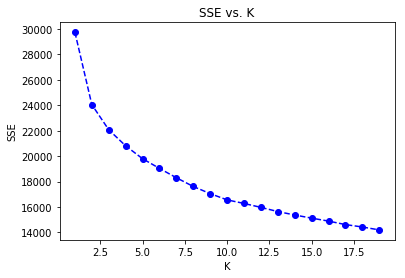

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def get_kmeans_score(data, center):
    # Over a number of different cluster counts...
    kmeans = KMeans(n_clusters=center)
    # run k-means clustering on the data and...
    model = kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score
    
scores = []
centers = list(range(1,20))

for center in centers:
    scores.append(get_kmeans_score(X_pca[:500,:], center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
    
    

In [71]:

kmeans = KMeans(n_clusters=3)

y_kmeans = kmeans.fit_predict(X_pca[:500,:])


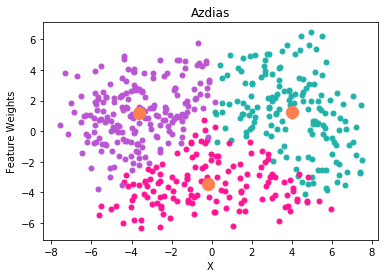

In [72]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


plt.scatter(X_pca[:500,:][y_kmeans==0, 0], X_pca[:500,:][y_kmeans==0, 1], s=25, c='lightseagreen', label ='Cluster 1')
plt.scatter(X_pca[:500,:][y_kmeans==1, 0], X_pca[:500,:][y_kmeans==1, 1], s=25, c='deeppink', label ='Cluster 2')
plt.scatter(X_pca[:500,:][y_kmeans==2, 0], X_pca[:500,:][y_kmeans==2, 1], s=25, c='mediumorchid', label ='Cluster 3')
# plt.scatter(X_pca[:500,:][y_kmeans==3, 0], X_pca[:500,:][y_kmeans==3, 1], s=25, c='magenta', label ='Cluster 4')
#plt.scatter(X_pca[:500,:][y_kmeans==4, 0], X_pca[:500,:][y_kmeans==4, 1], s=25, c='magenta', label ='Cluster 5')
# plt.scatter(X_pca[:500,:][y_kmeans==5, 0], X_pca[:500,:][y_kmeans==5, 1], s=25, c='salmon', label ='Cluster 6')
# plt.scatter(X_pca[:500,:][y_kmeans==6, 0], X_pca[:500,:][y_kmeans==6, 1], s=25, c='blue', label ='Cluster 7')
# plt.scatter(X_pca[:500,:][y_kmeans==7, 0], X_pca[:500,:][y_kmeans==7, 1], s=25, c='coral', label ='Cluster 8')
# plt.scatter(X_pca[:500,:][y_kmeans==8, 0], X_pca[:500,:][y_kmeans==8, 1], s=25, c='peachpuff', label ='Cluster 9')
# plt.scatter(X_pca[:500,:][y_kmeans==9, 0], X_pca[:500,:][y_kmeans==9, 1], s=25, c='violet', label ='Cluster 10')
# plt.scatter(X_pca[:500,:][y_kmeans==10, 0], X_pca[:500,:][y_kmeans==10, 1], s=25, c='green', label ='Cluster 11')
# plt.scatter(X_pca[:500,:][y_kmeans==11, 0], X_pca[:500,:][y_kmeans==11, 1], s=25, c='lightseagreen', label ='Cluster 12')

#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, c='coral', label = 'Centroids')

plt.title('Azdias')
plt.xlabel('X')
plt.ylabel('Feature Weights')
plt.show()

### Discussion 3.1: Apply Clustering to General Population

I have decided to separate my clusters into 3. I decided 3 due to the fact that it was the cleanest split. 4 clusters, in my opinion got a little too messy. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [73]:

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
encoder=OneHotEncoder(handle_unknown='ignore')

In [74]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean =  clean_data(customers, feat_info)

Converted 3,112,918 values to NaNs
Removed 0 columns with rows 300,000 or greater than NaN values
The columns that were removed are:[]
Removed 50,010 rows with columns 25 or greater than NaN values
Columns ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [75]:
print(customers_clean.shape)

(141642, 95)


In [76]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    
    return pca, X_pca

In [77]:
def pca_component_selection(df, n):
    '''Perform PCA with selected number of components on dataframe.
    Convert pca tuple to dataframe with column titles and indices labeled 'PCi'
    
    INPUT: dataframe the you wish to perform pca on
        
    OUTPUT: pca dataframe, X_pca
    '''
    df = df.copy()
    pca, X_pca = do_pca(n_components=n, data=df)
    pcnames = [f'PC{i+1}' for i in range(pca.n_components_)]
    df = pd.DataFrame(pca.components_, columns=list(df.columns), index=pcnames)
    return df, X_pca

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def get_kmeans(data, center):
    data = data.copy()
    kmeans = KMeans(n_clusters=center)
    kmeans.fit(data)
    return kmeans

def get_kmeans_score(data, center):
    
    data = data.copy()
    # Over a number of different cluster counts...
    kmeans = get_kmeans(data, center)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(data))
    return score
    

In [79]:
def plot_kmeans_elbow(df, X_pca):
    df = df.copy()
    #kmeans data
    k_means_data = df.values
    #get kmeans score and plot
    scores = []
    centers = list(range(1,20))

    for center in centers:
        scores.append(get_kmeans_score(X_pca, center))
    
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');
    return plt.show()

In [80]:
def k_means_scatter(df, center, X_pca):
    #kmeans clusters, fit, predict
    kmeans = get_kmeans(df, center)
    kmeans_predict = kmeans.fit_predict(X_pca)
    
#     kmeans = get_kmeans
#     kmeans_predict = kmeans.fit_predict(X_pca[:500,:])
    kmeans.labels_
    #kmeans scatter plot
    plt.scatter(X_pca[:500,:][kmeans_predict==0, 0], X_pca[:500,:][kmeans_predict==0, 1], s=25, c='lightseagreen', label ='Cluster 1')
    plt.scatter(X_pca[:500,:][kmeans_predict==1, 0], X_pca[:500,:][kmeans_predict==1, 1], s=25, c='deeppink', label ='Cluster 2')
    plt.scatter(X_pca[:500,:][kmeans_predict==2, 0], X_pca[:500,:][kmeans_predict==2, 1], s=25, c='mediumorchid', label ='Cluster 3')
    #centroid
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, c='coral', label = 'Centroids')

    plt.title('KMeans Scatter')
    plt.xlabel('X')
    plt.ylabel('Feature Weights')
    return plt.show(), kmeans_predict

In [81]:

def feat_trans_cluster(df, n, center):
    #nanimputer
    df = df.copy()
    df = nan_imputer(df)
    #apply pca
    df, X_pca = pca_component_selection(df, n)
#     get kmeans and kmeans score
#     kmeans, score = get_kmeans_score(df, center)
    #plot kmeans elbow
    data = plot_kmeans_elbow(df, X_pca[:500,:])
    #kmeans scatter plot
    data, kmeans_predict = k_means_scatter(df, center, X_pca[:500,:])
    return df, kmeans_predict
    

(797961, 89)


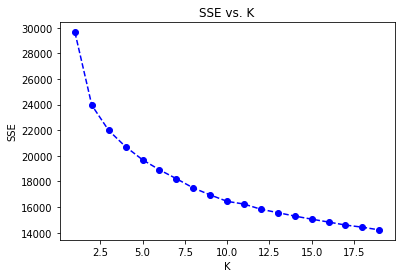

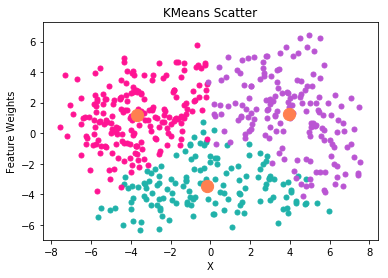

In [82]:
azdias, azdias_predict = feat_trans_cluster(azdias, 20, 3)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [83]:

# feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
# customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# customers_clean =  clean_data(customers, feat_info)
# customers, customers_predict = feat_trans_cluster(customers_clean, 20)

# azdias_clean =  clean_data(azdias, feat_info, encoder)
# azdias, azdias_predict = feat_trans_cluster(azdias, 20)




In [84]:
# print(customers_predict)

In [85]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d

In [86]:
#reload azdias
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
train_data =  clean_data(azdias, feat_info)
train_columns = train_data.columns.tolist()
model_imp = get_imputer(train_data)
train_data_imputed = model_imp.transform(train_data)
model_normalize = get_scaler(train_data_imputed)
train_data_imputed = model_normalize.transform(train_data_imputed)

# customers_normalize = fix_columns(customers_clean, customers_clean.columns.tolist())

model_pca = get_pca(train_data_imputed, 20)
train_data_imputed = model_pca.transform(train_data_imputed)
model_clusters = get_kmeans(train_data_imputed, 3)
train_data_imputed = model_clusters.predict(train_data_imputed)

# customer_clusters, customer_score = get_kmeans_score(customers_pca, 20)
# customer_clusters = kmeans.predict(customers_pca)

# azdias = imputer.transform(azdias_clean)
# azdias.columns = azdias_clean.columns
# scal = StandardScaler()
# azdias = pd.DataFrame(scal.transform(azdias))
# azdias.columns = azdias_clean.columns
# pca = do_PCA(n_components=3)
# pca.transform(azdias)
# azdias = pd.DataFrame(pca.transform(azdias))

# customers_imputer = imputer.transform(customers_clean)
# customers_normalize = scaler.transform(customers_imputer)
# customers_pca = pca.transform(customers_normalize)
# customer_clusters = kmeans.predict(customers_pca)

# azdias_inv = scal.inverse_transform(np.dot(azdias, pca.components_))[np.where(azdias_predict==0)]
# azdias_inv = pd.DataFrame(azdias_inv, columns=azdias_clean.columns)


Converted 8,373,929 values to NaNs
Removed 6 columns with rows 300,000 or greater than NaN values
The columns that were removed are:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Removed 93,260 rows with columns 25 or greater than NaN values
Columns ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [87]:
from sklearn.decomposition import PCA
#Load in customers data, clean, impute, scale, pca
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
test_clean =  clean_data(customers, feat_info)

test_clean = fix_columns(test_clean, train_columns)

test_imputer = model_imp.transform(test_clean)
test_normalize = model_normalize.transform(test_imputer)

test_pca = model_pca.transform(test_normalize)
test_clusters = model_clusters.predict(test_pca)





# customers_inv = scal.inverse_transform(np.dot(customers_clean, pca.components_))[np.where(customers_predict==0)]
# customers_inv = pd.DataFrame(customers_inv, columns=customers_clean.columns)


Converted 3,112,918 values to NaNs
Removed 0 columns with rows 300,000 or greater than NaN values
The columns that were removed are:[]
Removed 50,010 rows with columns 25 or greater than NaN values
Columns ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are of `categorical` type.
Multi level feature columns:['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Binary feature columns:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
set()
extra columns: {'GEBURTSJAHR', 'AGER_TYP'

v:[103350, 34579, 3713]
indexes:[0 1 2]
v1:[211480, 359558, 226923]
indexes1:[0 1 2]


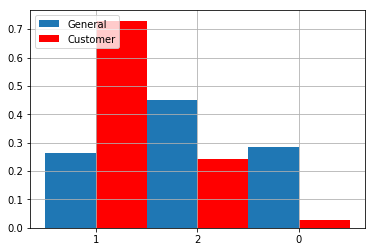

In [88]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Updated to reflect suggested approach
# https://knowledge.udacity.com/questions/905904

from collections import Counter

# generating proportion for the customer clusters.
labels, values = zip(*Counter(test_clusters).items())
v=list(values)
print(f'v:{v}')
v[:] = [x/len(test_clusters) for x in v]
indexes = np.arange(len(labels))
print(f'indexes:{indexes}')
# generating proportion for the azdias clusters.
labels1, values1 = zip(*Counter(train_data_imputed).items())
v1=list(values1)
print(f'v1:{v1}')
v1[:] = [x/len(train_data) for x in v1]
indexes1 = np.arange(len(labels))
print(f'indexes1:{indexes1}')


# configuring the graph
width = .5
plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()


In [89]:
# test_inv = scal.inverse_transform(np.dot(test_pca, pca.components_))[np.where(test_clusters==0)]
# test_inv = pd.DataFrame(azdias_inv, columns=azdias_clean.columns)

In [90]:
#Cluster1 is under represented in customer
customers_cluster_1 = model_normalize.inverse_transform(np.dot(test_pca, model_pca.components_))[np.where(test_clusters==1)]
customers_cluster_1 = pd.DataFrame(customers_cluster_1, columns=test_clean.columns)

In [91]:
customers_cluster_1 = customers_cluster_1.T
display(customers_cluster_1)

,0,1,2,3,4,5,6,7,8,9,...,103340,103341,103342,103343,103344,103345,103346,103347,103348,103349
ALTERSKATEGORIE_GROB,4.063418,3.500300,3.348018,3.590222,3.888420,2.843886,3.436205,3.488350,3.282347,2.992058,...,2.721200,2.725285,3.688704,3.740352,3.376039,2.778052,4.128921,4.228483,3.413579,2.266776
ANREDE_KZ,0.942932,0.992788,0.968975,1.037687,0.985619,1.024473,0.921657,0.955664,1.066643,1.079966,...,1.069621,1.070438,0.846107,1.099528,0.931867,1.074599,1.887976,1.149669,2.072132,1.054958
CJT_GESAMTTYP,2.373206,2.545803,2.307064,1.769287,2.196021,3.585375,3.328839,3.241159,3.805663,3.678306,...,4.489053,3.744128,2.506623,4.341626,4.201895,3.140292,2.206435,2.325305,2.912326,1.850040
FINANZ_MINIMALIST,5.062316,5.111081,4.324853,5.220839,5.232168,4.846411,4.923496,4.978484,4.290806,5.127300,...,4.403588,4.510565,5.121371,5.347072,4.456067,4.899731,3.826584,5.279747,2.855754,5.039463
FINANZ_SPARER,0.974848,1.093545,1.895908,1.171595,0.621714,2.389553,1.743107,1.889580,2.691177,1.109071,...,2.641749,1.515466,1.240147,1.118818,1.544729,1.096493,1.772876,0.802221,1.631824,1.281146
FINANZ_VORSORGER,4.947176,4.665743,4.187065,4.751698,4.909327,3.743369,3.998722,4.080955,3.558028,4.696325,...,3.241626,4.380636,4.575916,4.764078,4.522409,4.706433,4.239421,5.056384,4.847290,4.677378
FINANZ_ANLEGER,0.783069,1.801336,1.253815,1.445620,0.384927,2.171280,1.142668,2.887172,2.622003,0.884055,...,2.425419,1.040048,1.220897,1.391591,1.098667,0.009188,2.455023,1.093666,2.099010,1.759348
FINANZ_UNAUFFAELLIGER,2.525466,1.407305,2.324504,2.319426,1.790250,3.359646,3.094436,2.077635,3.324098,1.826993,...,3.203238,1.767627,2.358094,1.773774,1.672811,1.863102,2.498628,1.536379,1.932379,1.372319
FINANZ_HAUSBAUER,2.120806,1.976695,2.215718,1.742981,2.678515,1.159948,2.008052,1.343343,0.926190,2.283077,...,0.586783,2.918239,2.315068,1.668665,1.998242,2.049504,2.236280,2.010418,4.122057,1.719852
FINANZTYP,3.137742,5.518706,4.707869,3.666455,4.342455,3.123231,3.016594,4.971545,3.388868,4.940604,...,4.336704,5.342898,3.565214,5.157047,5.979211,5.493398,3.526914,4.875398,3.238171,5.955947


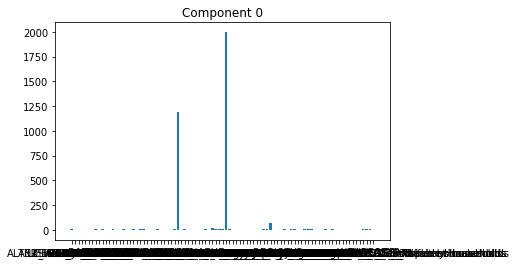

In [92]:
fig, ax = plt.subplots()

c_c = customers_cluster_1[0].sort_values(ascending=False)
# print(c_c)
index = list(c_c.index)
# print(fruits)
values = c_c.values
# print(counts)

ax.bar(index, values)

# # ax.set_ylabel('fruit supply')
ax.set_title('Component 0')
# # ax.legend(title='Fruit color')

plt.show()

MIN_GEBAEUDEJAHR                1996.027752
KBA13_ANZAHL_PKW                1189.403809
PRAEGENDE_JUGENDJAHRE_DECADE      67.401040
Name: 0, dtype: float64 ANZ_HAUSHALTE_AKTIV                                   -2.033590
WEALTH_STATUS_CAMEO_INTL_2015_Poorer households       -0.263696
WEALTH_STATUS_CAMEO_INTL_2015_Prosperous households   -0.260052
Name: 0, dtype: float64
MIN_GEBAEUDEJAHR                                       1996.027752
KBA13_ANZAHL_PKW                                       1189.403809
PRAEGENDE_JUGENDJAHRE_DECADE                             67.401040
ANZ_HAUSHALTE_AKTIV                                      -2.033590
WEALTH_STATUS_CAMEO_INTL_2015_Poorer households          -0.263696
WEALTH_STATUS_CAMEO_INTL_2015_Prosperous households      -0.260052
Name: 0, dtype: float64


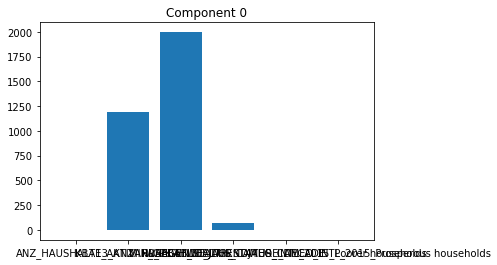

In [93]:
fig, ax = plt.subplots()
top_c_c = customers_cluster_1[0].sort_values(ascending=False)[:3]
bot_c_c = customers_cluster_1[0].sort_values(ascending=True)[:3]
print(top_c_c, bot_c_c)
top_bot_cc = pd.concat([top_c_c, bot_c_c])
print(top_bot_cc)

index = list(top_bot_cc.index)

values = top_bot_cc.values

ax.bar(index, values)

ax.set_title('Component 0')

plt.show()

MIN_GEBAEUDEJAHR
KBA13_ANZAHL_PKW
PRAEGENDE_JUGENDJAHRE_DECADE
ANZ_HAUSHALTE_AKTIV
WEALTH_STATUS_CAMEO_INTL_2015_Poorer households
WEALTH_STATUS_CAMEO_INTL_2015_Prosperous households


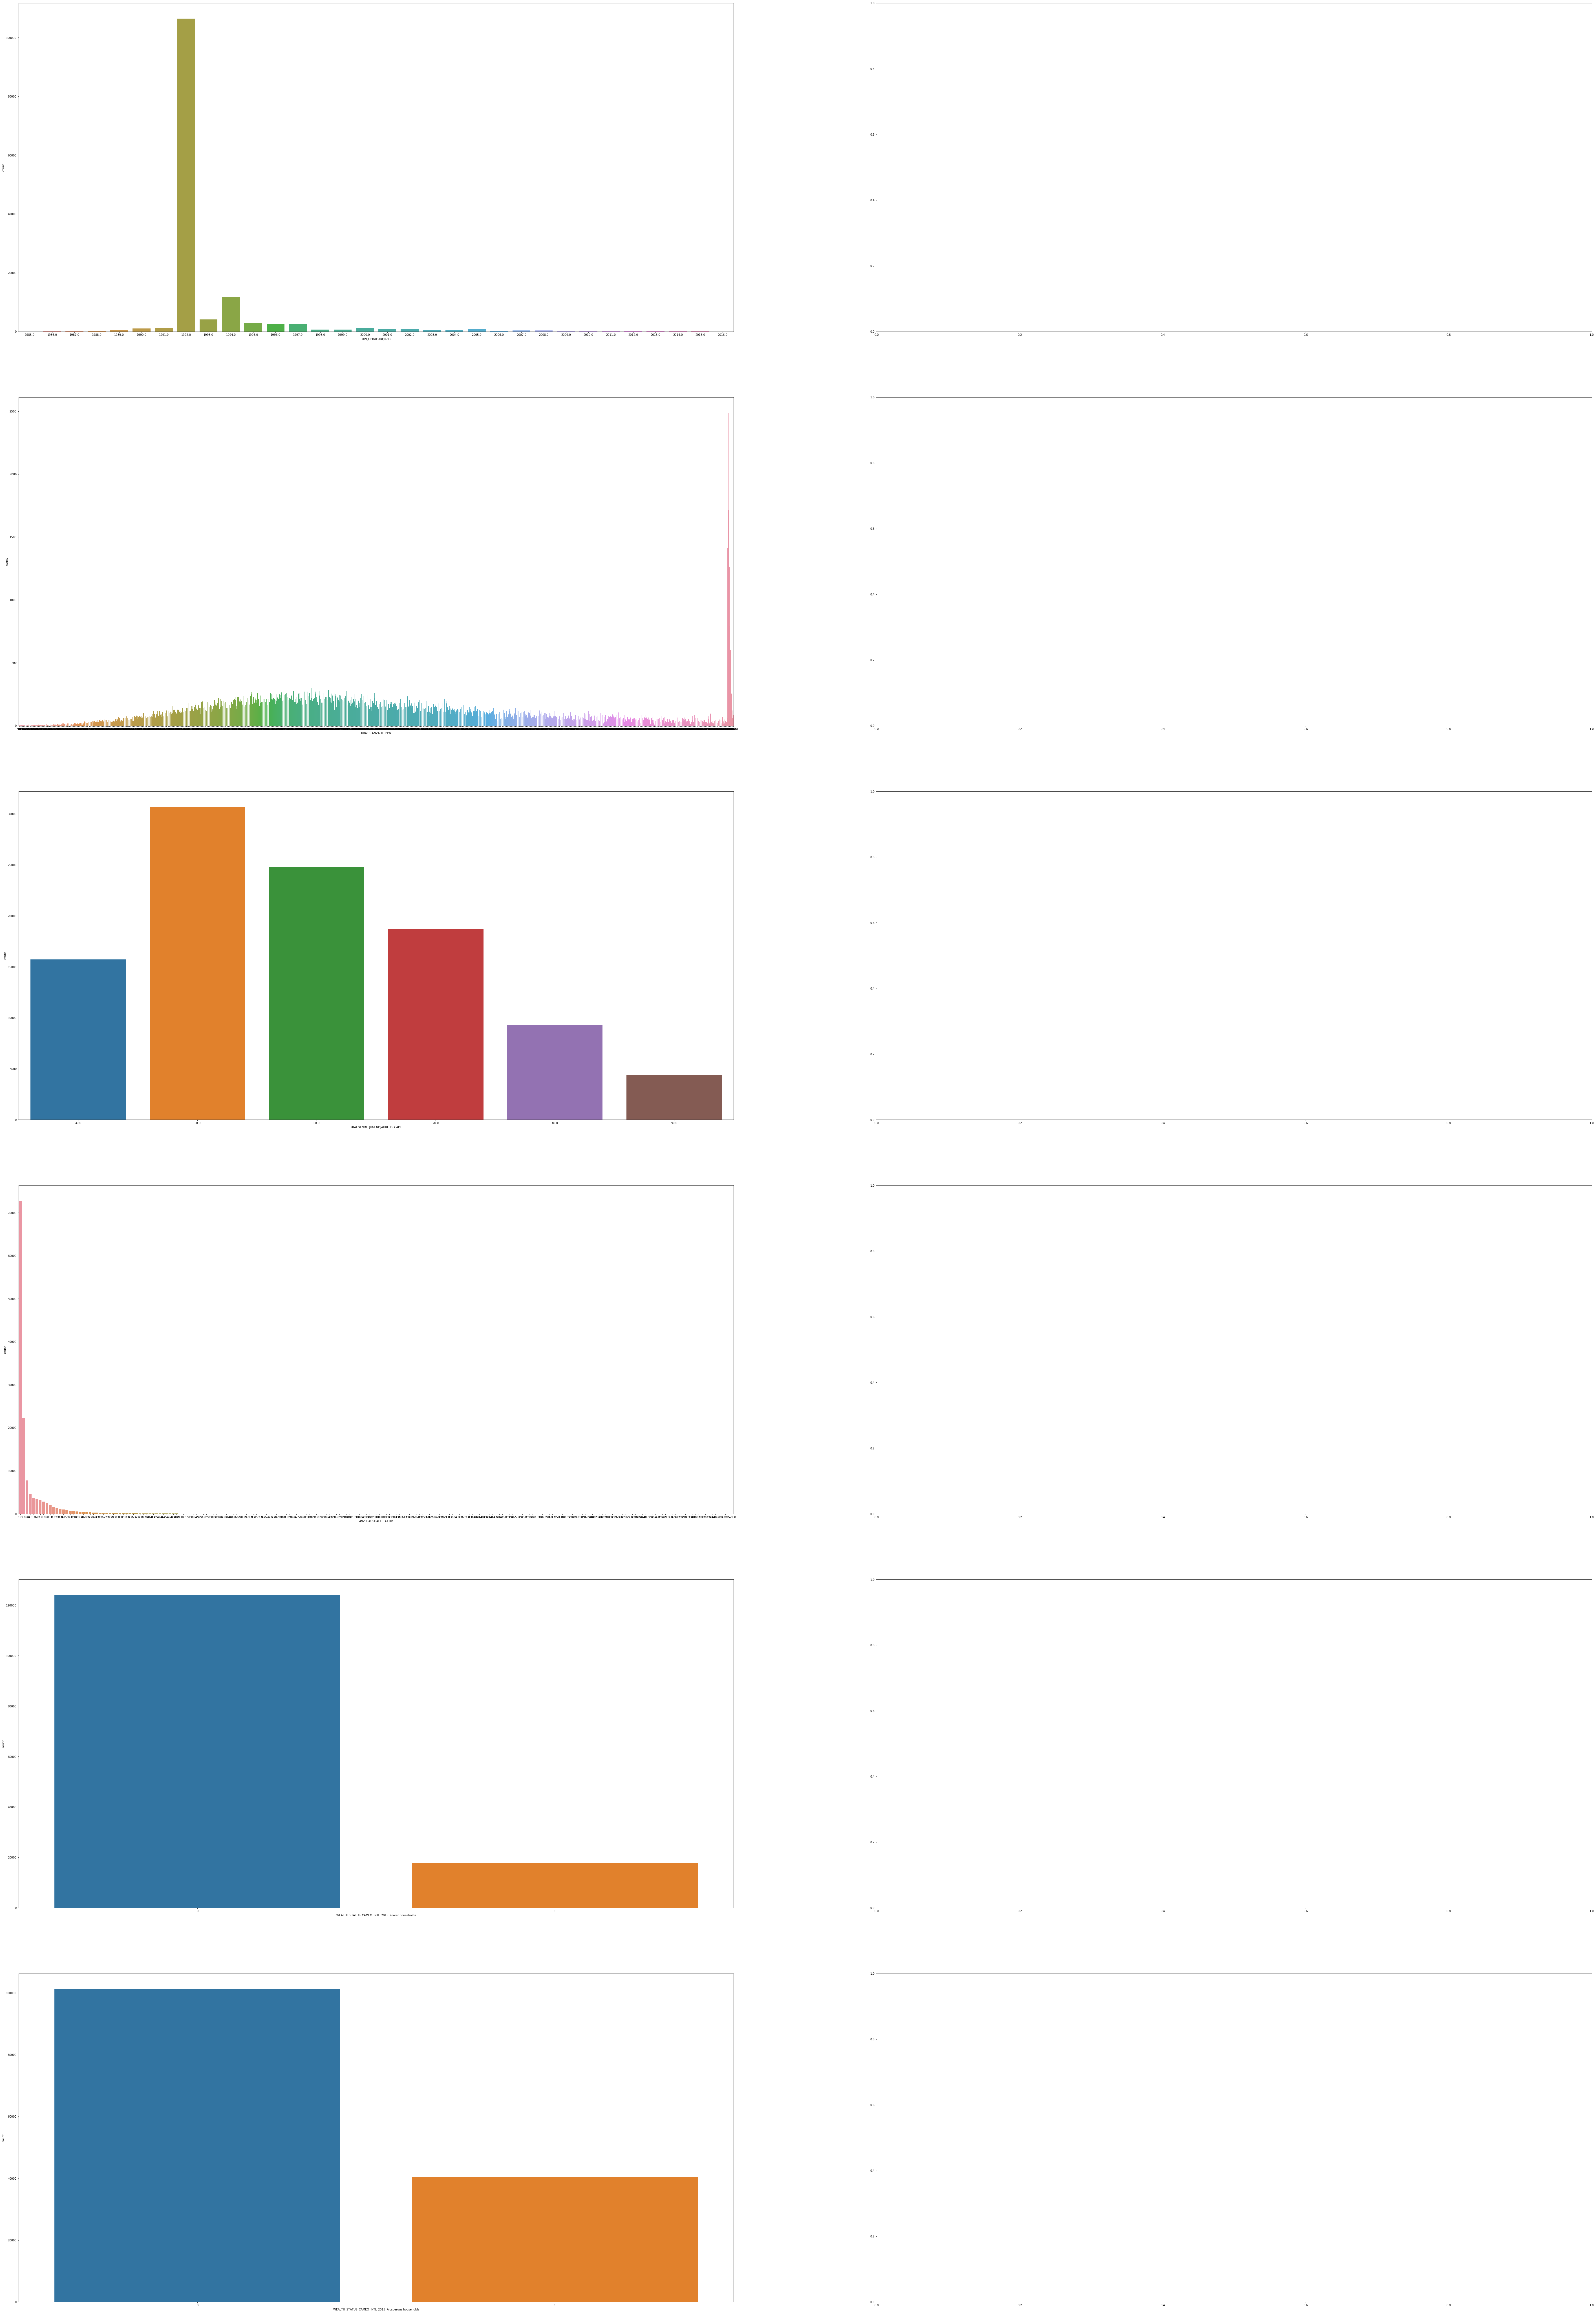

In [94]:
cols = test_clean[index].copy()
n = 0
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(100, 150))
for col in cols:
    print(col)
    sns.countplot(test_clean.loc[:, col], ax=axs[n,0])
#     axs[n,0].set_title('missing_data_high')
#     sns.countplot(azdias_remove_rows.loc[:, col], ax=axs[n,1])
#     axs[n,1].set_title('missing_data_low')
    n+=1

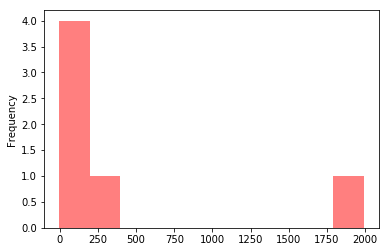

In [111]:
#######create matplotlib subplot with countplot as arg

###1992 in MIN_GEBAEUDEJAHR in highly overrepresented
# a certain number of cars is highly overrepresented in KBA13_ANZAHL_PKW                                     
# 50's is the most common decadePRAEGENDE_JUGENDJAHRE_DECADE                          
# 0 is most common in OST_WEST_KZ
# 0 is most common in LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement
# 0 is most common in WEALTH_STATUS_CAMEO_INTL_2015_Wealthy Households

p = top_bot_cc.plot(kind='hist', color='r', alpha=0.5)
# top_bot_cc = pd.DataFrame(top_bot_cc)
# display(top_bot_cc)
# cols = top_bot_cc.columns[:5]
# print(f'cols are:{cols}')
# n = 0
# fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 40))
# for col in cols:
#     sns.countplot(top_bot_cc.loc[:, col], ax=axs[n,0])
#     axs[n,0].set_title('missing_data_high')
#     sns.countplot(azdias_remove_rows.loc[:, col], ax=axs[n,1])
#     axs[n,1].set_title('missing_data_low')
#     n+=1

In [107]:
#Cluster 2  is over represented in customer
customers_cluster_2 = model_normalize.inverse_transform(np.dot(test_pca, model_pca.components_))[np.where(test_clusters==2)]
customers_cluster_2 = pd.DataFrame(customers_cluster_2, columns=test_clean.columns)
customers_cluster_2 = customers_cluster_2.T



In [108]:
customers_cluster_2.head()

,0,1,2,3,4,5,6,7,8,9,...,34569,34570,34571,34572,34573,34574,34575,34576,34577,34578
ALTERSKATEGORIE_GROB,4.054534,4.189111,4.184767,3.507798,2.999308,3.958075,3.317098,3.836753,4.455896,3.381763,...,3.954340,4.166637,3.478535,4.131941,3.257985,4.205149,3.779979,4.164848,3.944701,1.828783
ANREDE_KZ,1.898849,2.006024,1.807077,1.038888,1.178710,1.918231,1.917776,1.994325,1.105381,1.941891,...,1.679370,1.778355,2.044761,1.902736,0.854383,1.780957,1.068312,1.870930,1.802281,1.945465
CJT_GESAMTTYP,1.112584,2.528725,2.480209,2.003627,3.607394,1.632108,3.375502,2.988381,0.843321,3.257490,...,2.708718,2.393035,2.085873,2.884762,3.108569,2.324607,2.915835,2.212954,3.743777,2.407704
FINANZ_MINIMALIST,4.052500,2.301553,2.641324,3.747518,3.152527,3.094237,3.006996,2.620916,3.635434,2.305047,...,2.980953,3.075076,2.284793,2.278786,4.970566,2.422045,3.395877,2.715459,2.615742,2.574188
FINANZ_SPARER,1.438901,1.331257,1.393890,1.486297,2.318090,1.002015,1.824412,1.808944,0.791975,3.044080,...,1.271779,1.025092,1.631804,1.113541,1.617469,1.422763,1.759584,1.088548,2.330761,2.069111


MIN_GEBAEUDEJAHR                1992.188016
KBA13_ANZAHL_PKW                 367.435999
PRAEGENDE_JUGENDJAHRE_DECADE      60.072856
Name: 0, dtype: float64 ANZ_HAUSHALTE_AKTIV                              -2.439066
LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement   -0.196497
KBA05_ANTG4                                      -0.114371
Name: 0, dtype: float64
MIN_GEBAEUDEJAHR                                  1992.188016
KBA13_ANZAHL_PKW                                   367.435999
PRAEGENDE_JUGENDJAHRE_DECADE                        60.072856
ANZ_HAUSHALTE_AKTIV                                 -2.439066
LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement      -0.196497
KBA05_ANTG4                                         -0.114371
Name: 0, dtype: float64


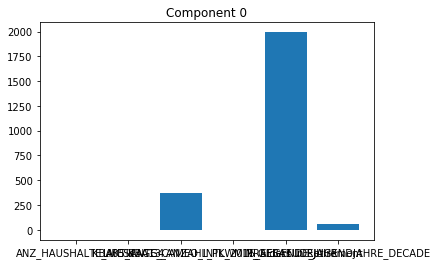

In [109]:
fig, ax = plt.subplots()
top_c_c = customers_cluster_2[0].sort_values(ascending=False)[:3]
bot_c_c = customers_cluster_2[0].sort_values(ascending=True)[:3]
print(top_c_c, bot_c_c)
top_bot_cc = pd.concat([top_c_c, bot_c_c])
print(top_bot_cc)

index = list(top_bot_cc.index)

values = top_bot_cc.values

ax.bar(index, values)

ax.set_title('Component 0')

plt.show()

MIN_GEBAEUDEJAHR
KBA13_ANZAHL_PKW
PRAEGENDE_JUGENDJAHRE_DECADE
ANZ_HAUSHALTE_AKTIV
LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement
KBA05_ANTG4


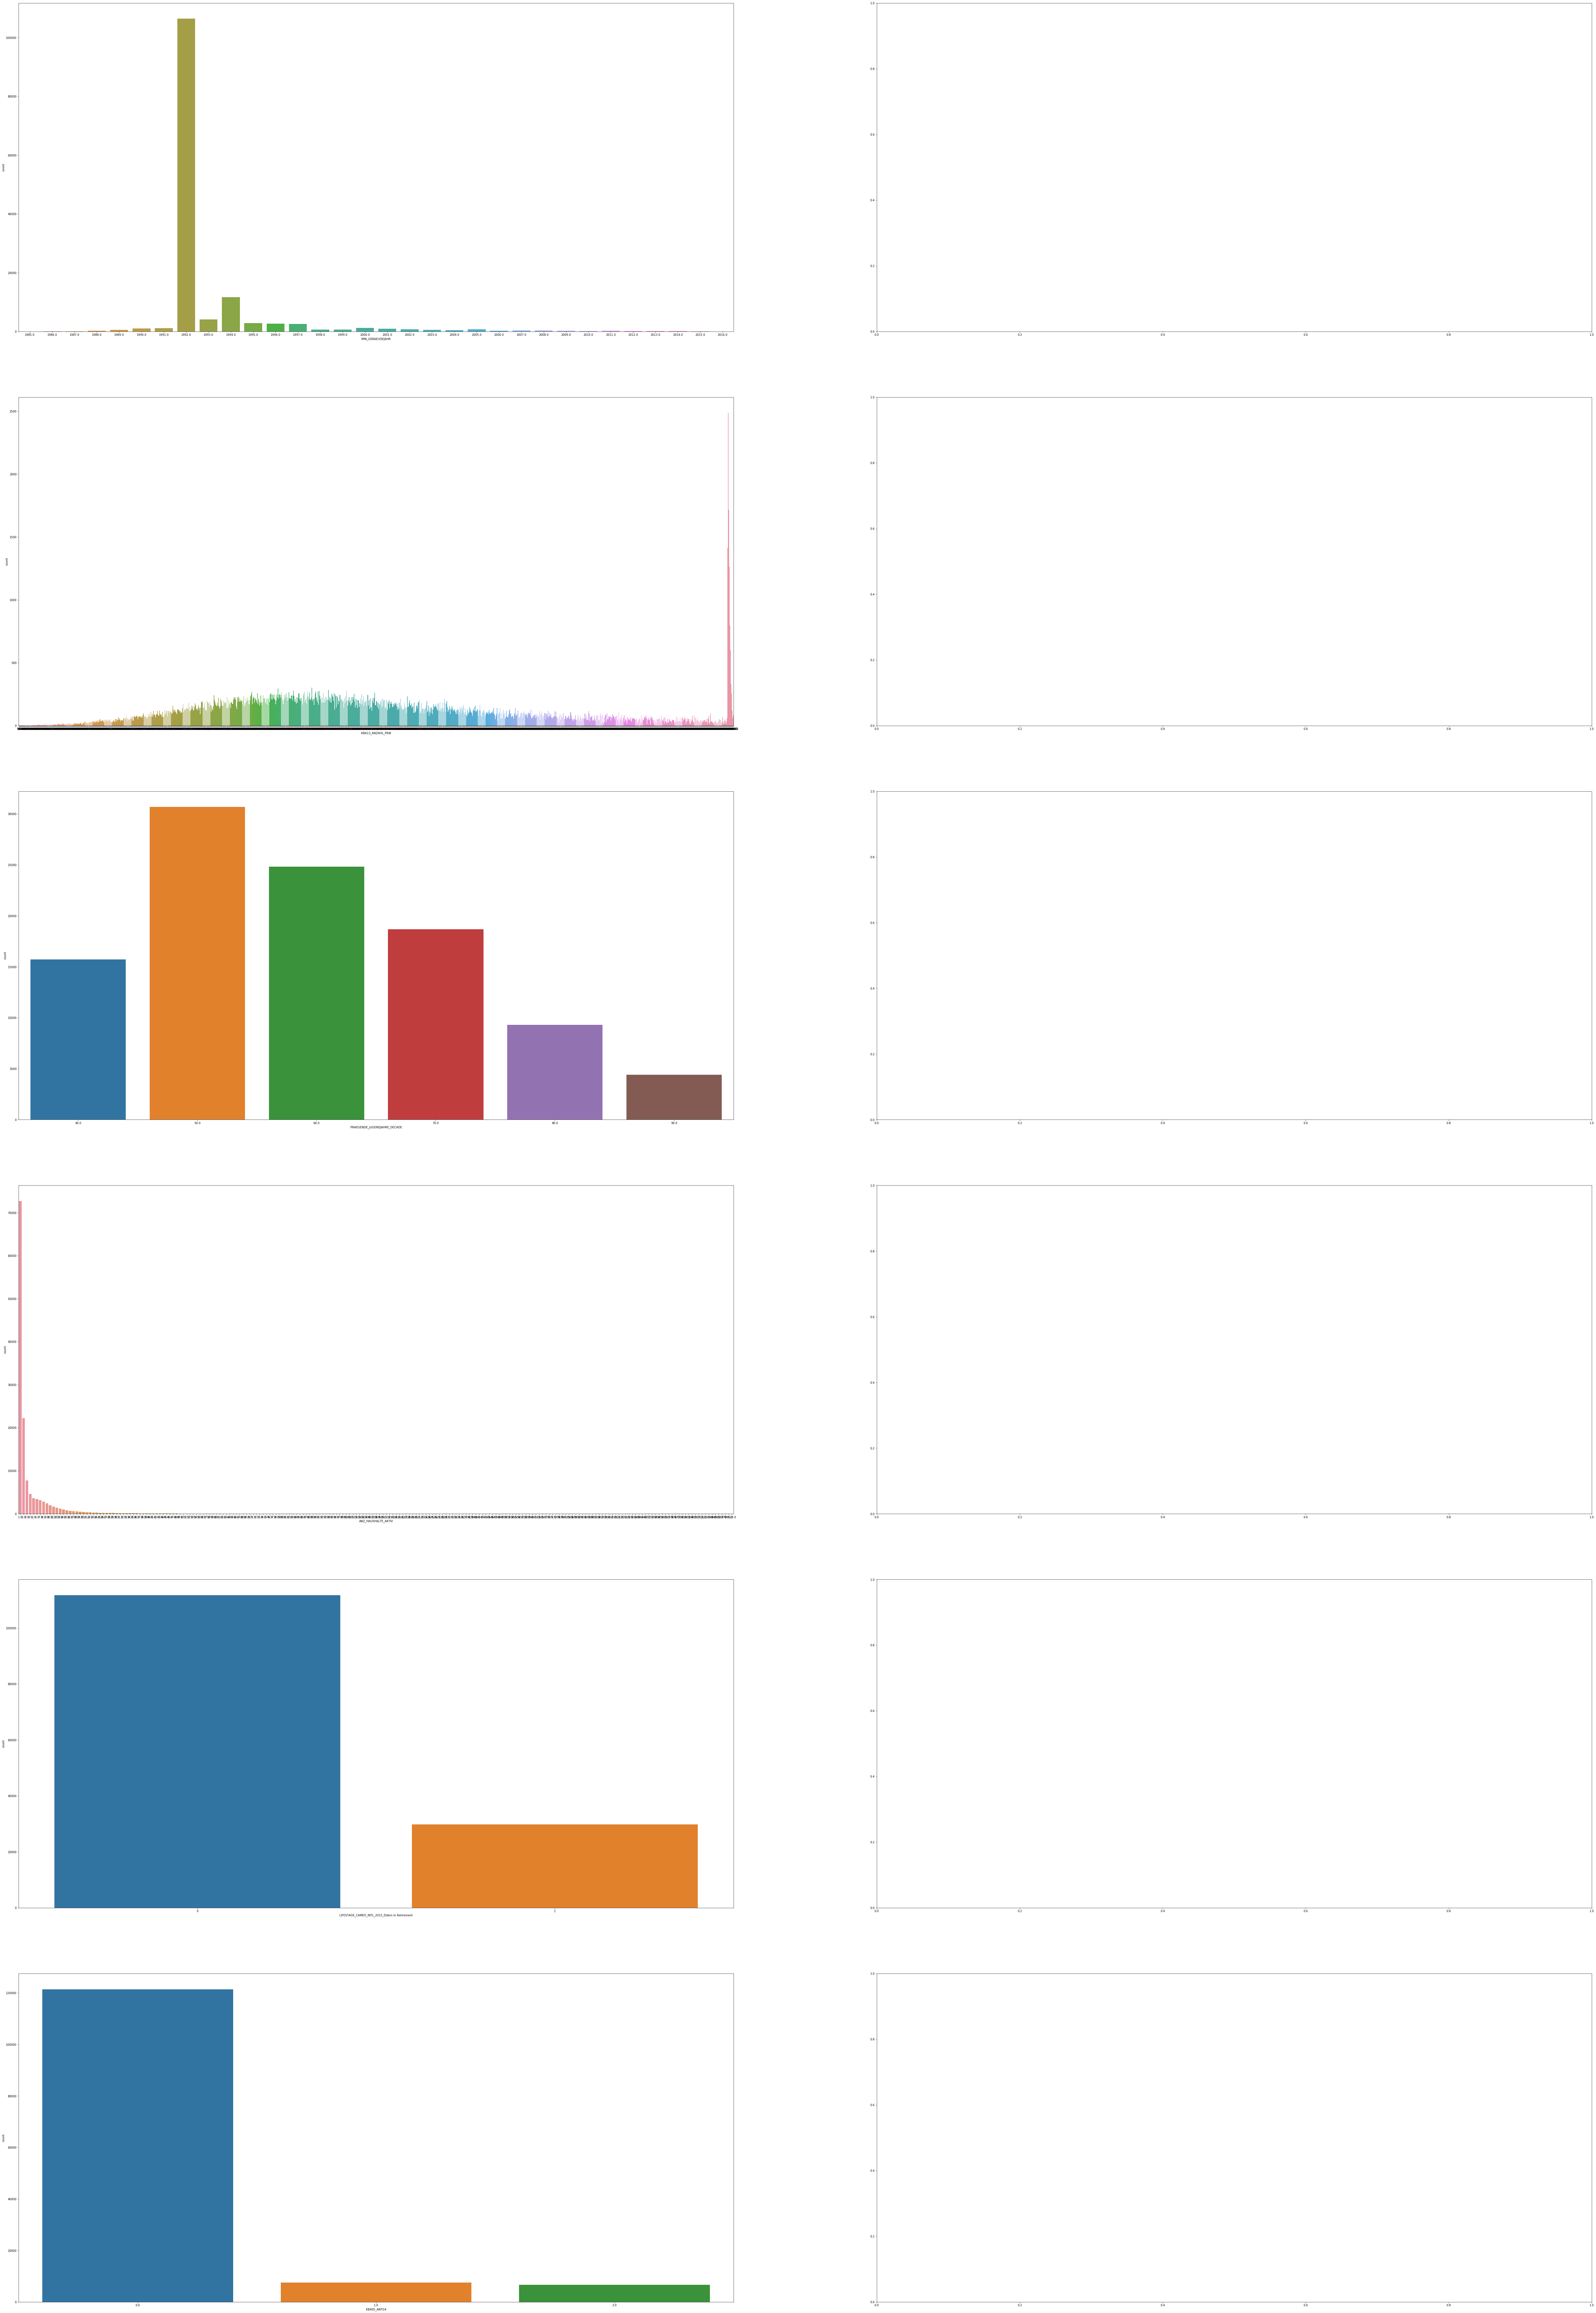

In [110]:
cols = test_clean[index].copy()
n = 0
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(100, 150))
for col in cols:
    print(col)
    sns.countplot(test_clean.loc[:, col], ax=axs[n,0])
#     axs[n,0].set_title('missing_data_high')
#     sns.countplot(azdias_remove_rows.loc[:, col], ax=axs[n,1])
#     axs[n,1].set_title('missing_data_low')
    n+=1

In [ ]:
#MIN_GEBAEUDEJAHR 1992
# certain number KBA13_ANZAHL_PKW  
# 50's PRAEGENDE_JUGENDJAHRE_DECADE
#1  in ANZ_HAUSHALTE_AKTIV 
#num of households in building
#0 in LIFESTAGE_CAMEO_INTL_2015_Elders In Retirement
#Pre-Family Couples & Singles
#0 in KBA05_ANTG4
#no 10+ family homes





In [ ]:
# centroids_cust = customers_inv.T
# centroids_azdias = azdias_inv.T

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')


# display(print('customer centroid 0 overrepresented:'),
#         centroids_cust.iloc[:,0].nlargest(3),
#         centroids_cust.iloc[:,0].nsmallest(3))
# display(print('general centroid 2 overrepresented:'),
#         centroids_azdias.iloc[:,2].nlargest(3),
#         centroids_azdias.iloc[:,2].nsmallest(3))
# display(print('general centroid 1 overrepresented:'),
#         centroids_azdias.iloc[:,1].nlargest(3),
#         centroids_azdias.iloc[:,1].nsmallest(3))


# a = pd.DataFrame(centroids_cust.iloc[:,0].nlargest(3))
# b = pd.DataFrame(centroids_cust.iloc[:,0].nsmallest(3))
# centroid_0 = pd.concat([a, b])


In [ ]:
# centroid_0 = centroid_0.T

In [ ]:
#create df of top and bottom overrepresented cols in centroid 0.
#plot of each col 

# cols = centroid_0.columns[:6]
# print(cols)

# n = 0
# fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 40))
# for col in cols:
#     print(col)
#     sns.countplot(customers_clean.loc[:, col], ax=axs[n,0])
#     axs[n,0].set_title('overrepresented_col')
# #     sns.countplot(customers_clean.loc[:, col], ax=axs[n,1])
# #     axs[n,1].set_title('overrepresented_col')
#     n+=1

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# display(print('general centroid 0 underrepresented:'),
#         centroids_azdias.iloc[:,0].nlargest(3),
#         centroids_azdias.iloc[:,0].nsmallest(3))
# display(print('customer centroid 2 underrepresented:'),
#         centroids_cust.iloc[:,2].nlargest(3),
#         centroids_azdias.iloc[:,2].nsmallest(3))
# display(print('customer centroid 1 underrepresented:'),
#         centroids_cust.iloc[:,1].nlargest(3),
#         centroids_cust.iloc[:,1].nsmallest(3))

# a = pd.DataFrame(centroids_azdias.iloc[:,0].nlargest(3))
# b = pd.DataFrame(centroids_azdias.iloc[:,0].nsmallest(3))
# centroid_0a = pd.concat([a, b])

In [ ]:
# centroid_0a = centroid_0a.T
# cols = centroid_0a.columns[:6]
# print(cols)

# n = 0
# fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 40))
# for col in cols:
#     print(col)
#     sns.countplot(azdias_clean.loc[:, col], ax=axs[n,1])
#     axs[n,0].set_title('underrepresented_col')
# #     sns.countplot(azdias_clean.loc[:, col], ax=axs[n,1])
# #     axs[n,1].set_title('underrepresented_col')
#     n+=1

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
in underrepresented cluster 1, we see that teh characteristics are mainly associated with
the income and retirement status.
in overrepresented cluster 2, we see that characteristics are mainly associately with couples and singles
as well as no 10+ family homes.

